In [64]:
import os
import pandas as pd
import time
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from keras import models, optimizers
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
#import warnings
#warnings.simplefilter('ignore')

**Format data into appropriate floating point tensors**
* Read the picture files
* Decode the JPEG content to RGB grids of pixels
* Convert these into floating point tensors
* Rescale the pixel values (between 0 and 255) to the [0,1] interval (neural networks prefer to deal with small input values)

#### Read data

In [41]:
train_dir = os.listdir('/Users/fi000980702/Documents/Work/Chapter5/dogs-cats-images/dataset/training')
test_dir = os.listdir('/Users/fi000980702/Documents/Work/Chapter5/dogs-cats-images/dataset/test')

In [56]:
def images_to_df(data):
    '''
    Args: list of images
    Func: loop images and create a dataframe with two 
          columns: filename and category where one equals dog and two equals cat
    Returns: dataframe
    '''
    filenames = []
    categories = []
    for file in data:
        category = file.split('.')[0]
        filenames.append(file)
        categories.append('dog') if category == 'dog' else categories.append('cat')
        
    df = pd.DataFrame({
        'filename': filenames,
        'category': categories
    })
    return df.sample(frac=1).reset_index(drop=True)

In [57]:
train_df = images_to_df(train_dir)
test_df = images_to_df(test_dir)

##### Data preprocessing

In [74]:
# Set up augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest')   
# test data not augmented
test_datagen = ImageDataGenerator(1./255) 

In [75]:
def generator(data, datagen, dir_, val, size=(128,128), batch_size=32):
    '''
    Args: dataframe of images and categories
    Func: preprocess dataframe of images into tensors 
    Return: preprocessed tensors
    '''
    generator = datagen.flow_from_directory(  
        dataframe=data,
        directory=dir_,
        target_size=size,  
        x_col='filename',
        y_col='category',
        batch_size=batch_size, 
        shuffle=val,                                # Shuffle training set but not valdiation set 
        class_mode='binary')
    return generator

In [76]:
train_generator = generator(train_df, train_datagen, '/Users/fi000980702/Documents/Work/Chapter5/dogs-cats-images/dataset/training', True)
test_generator = generator(test_df, test_datagen, '/Users/fi000980702/Documents/Work/Chapter5/dogs-cats-images/dataset/test', False)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [8]:
for data_batch, label_batch in train_generator:
    print('data batch shape {:d} rows and {:d} cols'.format(*data_batch.shape))
    print('label batch shape {:d} rows'.format(*label_batch.shape))
    break;

data batch shape 32 rows and 128 cols
label batch shape 32 rows


#### Define model

In [62]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

rmsprop = optimizers.RMSprop(lr=1e-4)
model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)       

In [63]:
start_time = time.time()                                                        

lr_plateau = ReduceLROnPlateau(
    monitor='val_acc', 
    patience=2, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100, 
    epochs=20,
    validation_data=test_generator, 
    validation_steps=50,
    callbacks=[lr_plateau])
 
total_time = (time.time() - start_time)/60                                     
print('Execution time {:2f} minutes'.format(total_time))                        


Epoch 1/20


/Users/fi000980702/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


100/100 [==============================] - 172s 2s/step - loss: 0.9859 - acc: 0.5798 - val_loss: 0.7731 - val_acc: 0.4450
Epoch 2/20
  4/100 [>.............................] - ETA: 2:17 - loss: 0.7470 - acc: 0.5469

KeyboardInterrupt: 

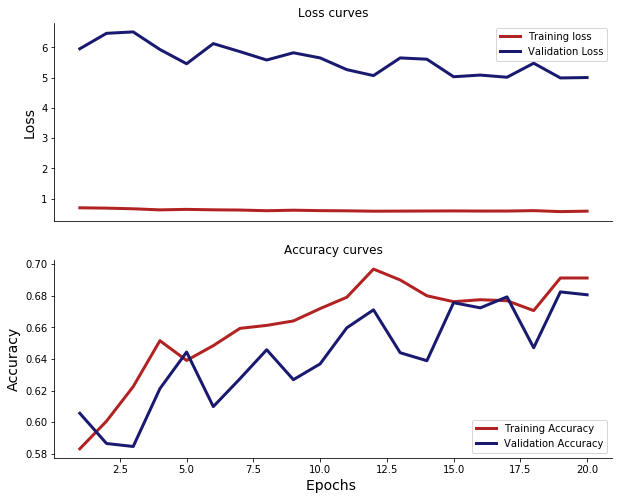

In [90]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,8))

history_dict = history.history
epochs = range(1, len(history_dict['acc'])+1)

ax0.plot(epochs, history_dict['loss'], 'firebrick', linewidth=3.0)
ax0.plot(epochs, history_dict['val_loss'], 'midnightblue', linewidth=3.0)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.tick_params(bottom=False)
ax0.set_xticklabels([])
ax0.set_title('Loss curves')
ax0.set_ylabel('Loss', fontsize=14)
ax0.legend(['Training loss', 'Validation Loss'], loc='best')

ax1.plot(epochs, history_dict['acc'], 'firebrick', linewidth=3.0)
ax1.plot(epochs, history_dict['val_acc'], 'midnightblue' ,linewidth=3.0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Accuracy curves')
ax1.set_xlabel('Epochs ', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')